In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=40
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

54

(40, 256, 256, 3)
[0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 2 1 1 1 0 1 0 1 0 0
 1 1 0]


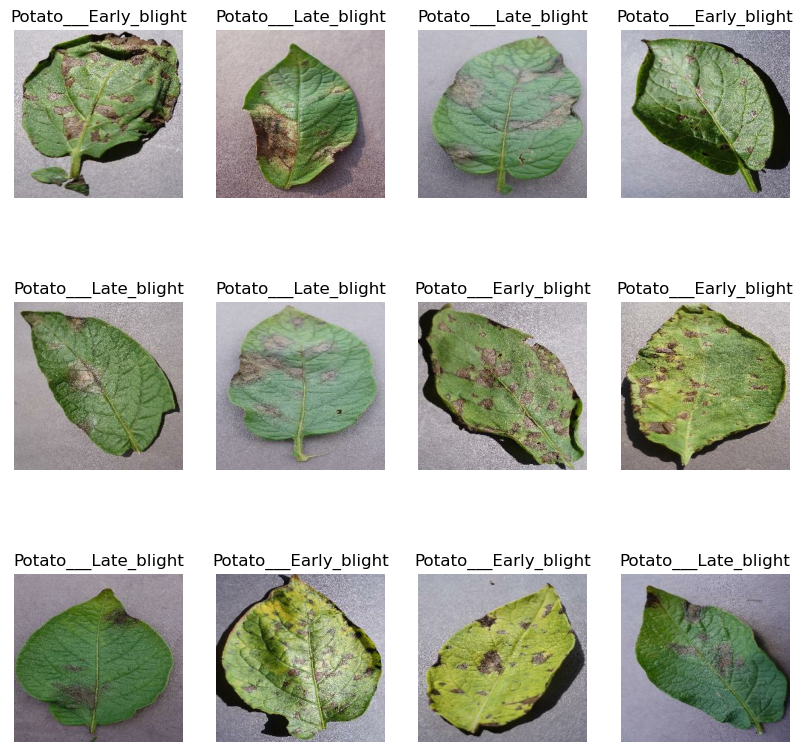

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

43 5 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (40, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (40, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (40, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (40, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
43/43 [==============================] - 93s 2s/step - loss: 0.8967 - accuracy: 0.5129 - val_loss: 0.7118 - val_accuracy: 0.7050
Epoch 2/20
43/43 [==============================] - 68s 2s/step - loss: 0.5645 - accuracy: 0.7605 - val_loss: 0.4917 - val_accuracy: 0.8150
Epoch 3/20
43/43 [==============================] - 71s 2s/step - loss: 0.4080 - accuracy: 0.8347 - val_loss: 0.3495 - val_accuracy: 0.8550
Epoch 4/20
43/43 [==============================] - 68s 2s/step - loss: 0.3057 - accuracy: 0.8715 - val_loss: 0.2221 - val_accuracy: 0.9100
Epoch 5/20
43/43 [==============================] - 68s 2s/step - loss: 0.2587 - accuracy: 0.8937 - val_loss: 0.2527 - val_accuracy: 0.8800
Epoch 6/20
43/43 [==============================] - 68s 2s/step - loss: 0.2422 - accuracy: 0.8949 - val_loss: 0.2429 - val_accuracy: 0.8900
Epoch 7/20
43/43 [==============================] - 80s 2s/step - loss: 0.1704 - accuracy: 0.9352 - val_loss: 0.2285 - val_accuracy: 0.8850
Epoch 8/20
43/43 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 5s 526ms/step - loss: 0.1135 - accuracy: 0.9625


[0.11351661384105682, 0.9624999761581421]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8967286348342896,
 0.5645287036895752,
 0.40797391533851624,
 0.30568981170654297,
 0.2586515545845032,
 0.2421894669532776,
 0.17037731409072876,
 0.14090321958065033,
 0.18921269476413727,
 0.12401900440454483,
 0.09952040761709213,
 0.07114792615175247,
 0.1253574639558792,
 0.09329889714717865,
 0.04066530242562294,
 0.129510298371315,
 0.0904511958360672,
 0.04664423316717148,
 0.0741318017244339,
 0.05840817466378212]

In [16]:
history.history['accuracy']

[0.5128504633903503,
 0.7605140209197998,
 0.8346962332725525,
 0.8714953064918518,
 0.8936915993690491,
 0.894859790802002,
 0.9351635575294495,
 0.9392523169517517,
 0.9252336621284485,
 0.957359790802002,
 0.9643691778182983,
 0.9778037667274475,
 0.9526869058609009,
 0.9637850522994995,
 0.9848130941390991,
 0.9596962332725525,
 0.9678738117218018,
 0.9836448431015015,
 0.9725467562675476,
 0.9795560836791992]

In [17]:
history.history['val_loss']

[0.7118092179298401,
 0.49171680212020874,
 0.3494526743888855,
 0.2220849096775055,
 0.25271889567375183,
 0.24286440014839172,
 0.22851938009262085,
 0.14811763167381287,
 0.13555574417114258,
 0.20862117409706116,
 0.7004687786102295,
 0.08931088447570801,
 0.05387040600180626,
 0.04753424972295761,
 1.3150320053100586,
 0.10801444202661514,
 0.11787863075733185,
 0.36975571513175964,
 0.12428116798400879,
 0.15784339606761932]

In [18]:
history.history['val_accuracy']

[0.7049999833106995,
 0.8149999976158142,
 0.8550000190734863,
 0.9100000262260437,
 0.8799999952316284,
 0.8899999856948853,
 0.8849999904632568,
 0.9350000023841858,
 0.9750000238418579,
 0.9200000166893005,
 0.75,
 0.9649999737739563,
 0.9900000095367432,
 0.9900000095367432,
 0.7350000143051147,
 0.9599999785423279,
 0.9700000286102295,
 0.875,
 0.9549999833106995,
 0.9549999833106995]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

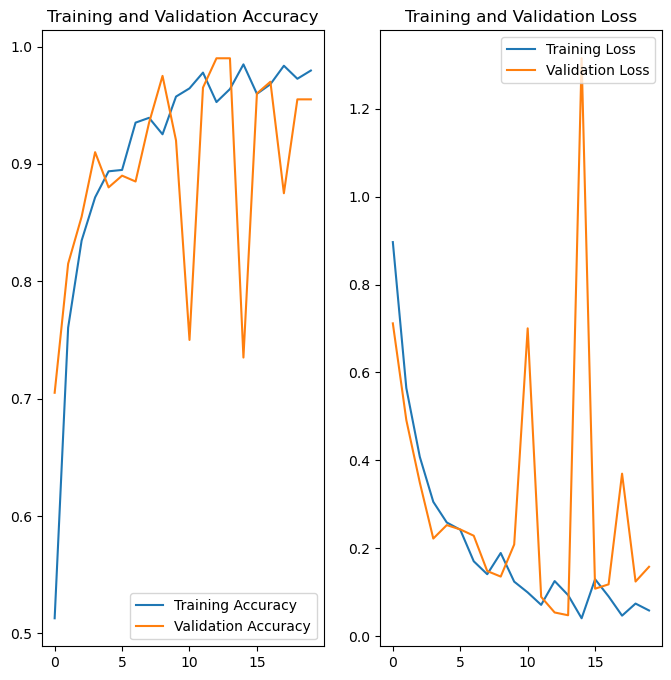

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

2/2 [==============================] - 0s 68ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


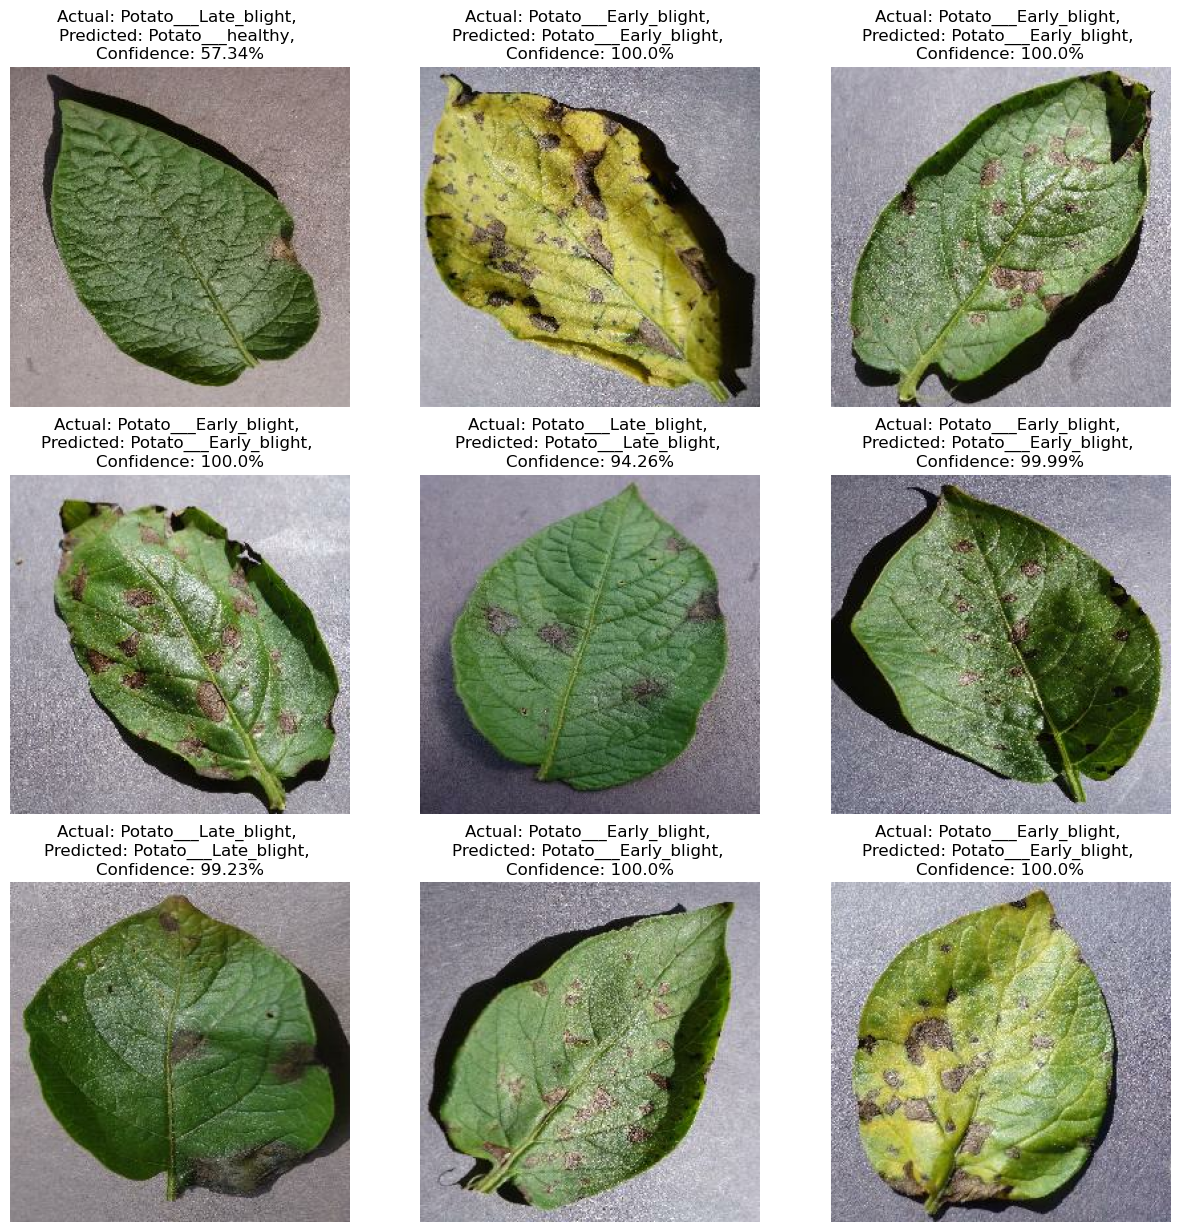

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       111
           1       1.00      0.92      0.96       112
           2       0.74      1.00      0.85        17

    accuracy                           0.96       240
   macro avg       0.90      0.97      0.93       240
weighted avg       0.97      0.96      0.96       240



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[111,   0,   0],
       [  3, 103,   6],
       [  0,   0,  17]])>

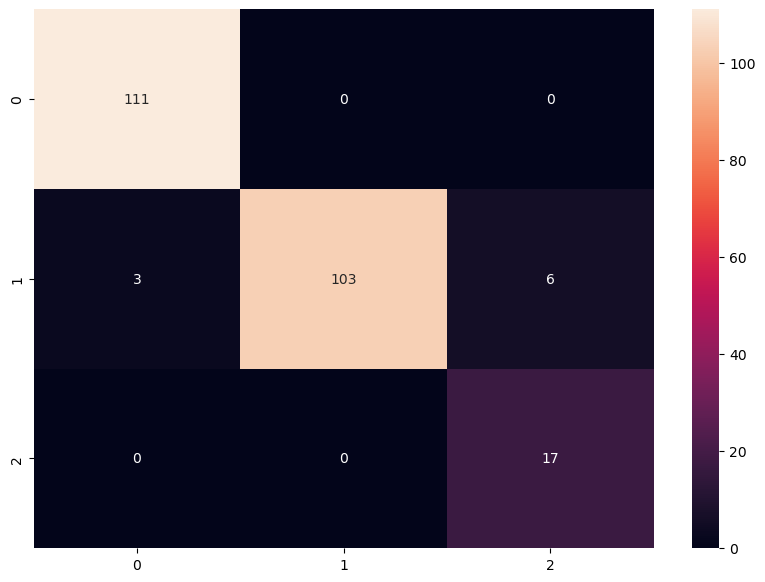

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-BatchSize40.joblib"
joblib.dump(model, filename)

['Model1-BatchSize40.joblib']